#Описание данных
Данные получены из Репозитория UCI (UCI Machine Learning Repository) - https://archive.ics.uci.edu/ml/datasets/Wine - и представляют собой результаты химического анализа вин, произведенных из винограда 3 различных видов, выращенных в одном регионе Италии. Всего выборка содержит 178 наблюдений 14-ти признаков: 
*   Class - принадлежность вина определенному сорту винограда;
*   Alcohol - содержание алкоголя в вине;
*   Malic acid - содержание яблочной кислоты в вине;
*   Ash - содержание зольных элементов в вине;
*   Alcalinity of ash - щелочность золы в вине;
*   Magnesium - содержание магний в вине;
*   Phenols - общее содержание фенолов в вине;
*   Flavonoids - общее содержание флавоноидов в вине;
*   Nonflavonoid phenols - содержание нефлавоноидных фенолов в вине;
*   Proanthocyanins - содержаение проантоцианидов в вине;
*   Color intensity - насыщенность цвета вина;
*   Hue - оттенок вина;
*   OD280_OD315 - содержание белка в вине, определенное методикой OD280/OD315 разбавленных вин;
*   Proline - содержание пролина в вине.

#Цель проекта
Выявить наилучший алгоритм классификации сорта винограда, из которого было произведено вино, среди простого k-NN и взвешенного k-NN (при k, равным от 2 до 5) и наивного байесовского классификатора.

#Загрузка и предварительная обработка данных
Импортируем необходимые библиотеки

In [86]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем данные из файла

In [9]:
df = pd.read_csv("/content/drive/MyDrive/ITMO/wine+.csv", delimiter=',')
df

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Phenols,Flavonoids,Nonflavonoid phenols,Proanthocyanins,Color intensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Отбор предикторов и откликов

In [19]:
X = pd.DataFrame(df.drop(['Class'], axis=1))
y = pd.DataFrame(df['Class']).values.ravel()

Использование МГК для уменьшения размерности до 2-х, построение графика зависимости доли объясненной дисперсии от количества используемых ГК. Видно, что объясняемая двумя ГК дисперсия равна 1.

In [20]:
pca = PCA(n_components = 2, svd_solver = 'full')
X_trans = pca.fit_transform(X)
explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)
explained_variance

array([0.998, 1.   ])

Графическое представление выборки с учетом откликов. Интуитивная классификация с учетом применения МГК очевидно затруднена.

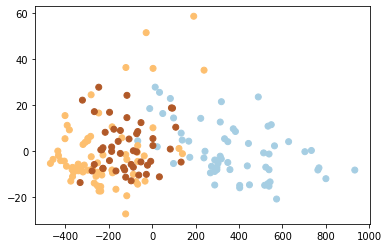

In [21]:
plt.scatter(X_trans[:len(X_trans), 0], X_trans[:len(X_trans), 1], c=y[:len(y)], cmap = 'Paired')

Преобразование ГК в датафрейм и создание столбца индекса для удобства

In [22]:
X_pca = pd.DataFrame(X_trans, columns = ['pca_1','pca_2'])
X_pca.insert(0, 'id', range(1, 1 + len(X_pca)))
X_pca.set_index('id', inplace = True)
X_pca

,pca_1,pca_2
id,,
1,318.562979,21.492131
2,303.097420,-5.364718
3,438.061133,-6.537309
4,733.240139,0.192729
5,-11.571428,18.489995
...,...,...
174,-6.980211,-4.541137
175,3.131605,2.335191
176,88.458074,18.776285


Cравнение эффективности различных моделей классификации методом k-блочной кросс-валидации

In [107]:
models = []
models.append(("kNN_2 -",KNeighborsClassifier(n_neighbors=2,p=2))) #Простой kNN при k от 2 до 5
models.append(("kNN_3 -",KNeighborsClassifier(n_neighbors=3,p=2)))
models.append(("kNN_4 -",KNeighborsClassifier(n_neighbors=4,p=2)))
models.append(("kNN_5 -",KNeighborsClassifier(n_neighbors=5,p=2)))
models.append(("kNNweighted_2 -",KNeighborsClassifier(n_neighbors=2,weights='distance',p=2))) #Взвешенный kNN  при k от 2 до 5
models.append(("kNNweighted_3 -",KNeighborsClassifier(n_neighbors=3,weights='distance',p=2)))
models.append(("kNNweighted_4 -",KNeighborsClassifier(n_neighbors=4,weights='distance',p=2)))
models.append(("kNNweighted_5 -",KNeighborsClassifier(n_neighbors=5,weights='distance',p=2)))
models.append(("Bayes -",GaussianNB())) #Наивный байесовский классификатор

Подготовка вывода результатов

In [108]:
cv = KFold(n_splits=10, random_state=1, shuffle=True) #Установка параметров k-блочной валидации: разбивка на 10 частей с перемешиванием выборки
results = []
names = []
for name,model in models:
  result = cross_val_score(model, X_pca, y, scoring = 'accuracy', cv=cv)
  names.append(name)
  results.append(result)

Вывод результатов

In [109]:
for i in range(len(names)):
  print(names[i],np.mean(results[i]))

kNN_2 - 0.6728758169934641
kNN_3 - 0.6970588235294117
kNN_4 - 0.6741830065359478
kNN_5 - 0.6794117647058824
kNNweighted_2 - 0.723202614379085
kNNweighted_3 - 0.7124183006535948
kNNweighted_4 - 0.7183006535947712
kNNweighted_5 - 0.7235294117647059
Bayes - 0.7408496732026143


Представим получившийся результат графически

[(0.6, 0.8)]

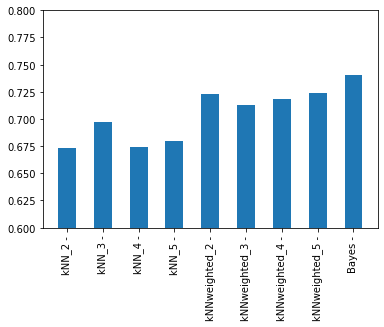

In [111]:
fig, ax = plt.subplots()
plot = []
algorithms = []
for i in range(len(names)):
  plot.append(np.mean(results[i]))
for i in range(len(names)):
  algorithms.append(names[i])
plt.bar(algorithms,plot,width=0.5)
plt.xticks(rotation='vertical')
ax.set(ylim=[0.6, 0.8])

Можно видеть, что в целом использованные алгоритмы не очень точно могут выполнять поставленную задачу (классификации точны в 65-75% случаев), однако из протестированных наиболее эффективным для применения будет наивный байесовский алгоритм классификации либо различные варианты взвешенного k-NN, которые незначительно отличаются от него по точности.